# BTC Predictor

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [2]:
import json as js
import numpy as np
import pandas as pd
from ta import *
#from fastai.structured import *
#from fastai.column_data import *

class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_train_validation(self, testRecordsCount, trainRecordsCount):
        self.test = self.train.tail(testRecordsCount)
        self.train = self.train.head(trainRecordsCount)
#        self.test.reset_index(inplace=True)
#        self.train.reset_index(inplace=True)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        #     df = df.dropna()
        #     df = df.replace(np.nan,df.mean())
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['maxc5'] = self.get_max_lookback("Close", 5)
        self.train['maxc15'] = self.get_max_lookback("Close", 15)
        self.train['maxc30'] = self.get_max_lookback("Close", 30)
        self.train['maxc60'] = self.get_max_lookback("Close", 60)
        self.train['maxc90'] = self.get_max_lookback("Close", 90)
        self.train['maxh5'] = self.get_max_lookback("High", 5)
        self.train['maxh15'] = self.get_max_lookback("High", 15)
        self.train['maxh30'] = self.get_max_lookback("High", 30)
        self.train['maxh60'] = self.get_max_lookback("High", 60)
        self.train['maxh90'] = self.get_max_lookback("High", 90)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(np.float32)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 20
percentIncrease = 1.002
recordsCount = 110000
testRecordsCount = 10000
trainRecordsCount = 100000
trainRatio = 0.8
lr = 1e-4
dropout = 0.01
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [5]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [9]:
train= tables[0]

In [10]:
# train = train.head(1500000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 110000 Original size: 1819074


## Data Cleaning

In [11]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close
1709074,2018-04-11 14:41:00,1.658177,6950.01,6950.01,6950.00,6950.01
1709075,2018-04-11 14:42:00,9.377500,6950.01,6950.01,6949.91,6949.92
1709076,2018-04-11 14:43:00,6.000195,6949.91,6949.91,6945.99,6946.00
1709077,2018-04-11 14:44:00,1.164831,6946.00,6946.00,6944.99,6945.00
1709078,2018-04-11 14:45:00,0.513527,6945.00,6945.00,6944.99,6944.99


## Join Bitstamp

In [12]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [13]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [14]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 33005 Sell count: 76995


In [15]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:607: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:629: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


Train size: 110000


In [16]:
p.add_date_values()

## Split validation and test sets

In [17]:
p.split_train_validation(testRecordsCount, trainRecordsCount)

Train size: 100000 Test size: 10000


In [18]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,action,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1709074,2018-04-11 14:41:00,1.658177,6950.01,6950.01,6950.00,6950.01,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1000.000000,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,0.0,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.010000,6950.010000,6950.010000,6950.010000,6950.010000,2018,4,15,11,2,101,False,False,False,False,False,False,1523457660,14,41
1709075,2018-04-11 14:42:00,9.377500,6950.01,6950.01,6949.91,6949.92,0,-5.843823,-9.377500,0.0,0.0,0.000000,0.0,0.000000,1000.000000,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.001295,-0.001295,-0.001295,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6949.965000,6949.965000,6949.965000,6949.965000,6949.965000,2018,4,15,11,2,101,False,False,False,False,False,False,1523457720,14,42
1709076,2018-04-11 14:43:00,6.000195,6949.91,6949.91,6945.99,6946.00,0,-13.471581,-6.000195,0.0,0.0,-17.411492,0.0,-0.003506,999.435965,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.056404,-0.056419,-0.057698,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6948.643333,6948.643333,6948.643333,6948.643333,6948.643333,2018,4,15,11,2,101,False,False,False,False,False,False,1523457780,14,43
1709077,2018-04-11 14:44:00,1.164831,6946.00,6946.00,6944.99,6945.00,0,-7.111346,-1.164831,0.0,0.0,40.406332,0.0,-0.003552,999.292078,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.014397,-0.014398,-0.072086,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6947.732500,6947.732500,6947.732500,6947.732500,6947.732500,2018,4,15,11,2,101,False,False,False,False,False,False,1523457840,14,44
1709078,2018-04-11 14:45:00,0.513527,6945.00,6945.00,6944.99,6944.99,0,-1.655292,-0.513527,0.0,0.0,5.541534,0.0,-0.000168,999.290639,0.0,6951.063567,6936.719433,6943.8915,0.0

In [19]:
p.train.tail(50).T.head(100)

,1809024,1809025,1809026,1809027,1809028,1809029,1809030,1809031,1809032,1809033,1809034,1809035,1809036,1809037,1809038,1809039,1809040,1809041,1809042,1809043,1809044,1809045,1809046,1809047,1809048,1809049,1809050,1809051,1809052,1809053,1809054,1809055,1809056,1809057,1809058,1809059,1809060,1809061,1809062,1809063,1809064,1809065,1809066,1809067,1809068,1809069,1809070,1809071,1809072,1809073
Timestamp,2018-06-20 00:31:00,2018-06-20 00:32:00,2018-06-20 00:33:00,2018-06-20 00:34:00,2018-06-20 00:35:00,2018-06-20 00:36:00,2018-06-20 00:37:00,2018-06-20 00:38:00,2018-06-20 00:39:00,2018-06-20 00:40:00,2018-06-20 00:41:00,2018-06-20 00:42:00,2018-06-20 00:43:00,2018-06-20 00:44:00,2018-06-20 00:45:00,2018-06-20 00:46:00,2018-06-20 00:47:00,2018-06-20 00:48:00,2018-06-20 00:49:00,2018-06-20 00:50:00,2018-06-20 00:51:00,2018-06-20 00:52:00,2018-06-20 00:53:00,2018-06-20 00:54:00,2018-06-20 00:55:00,2018-06-20 00:56:00,2018-06-20 00:57:00,2018-06-20 00:58:00,2018-06-20 00:59:00,2018-06-20 01:00:00,2018-06-20 01:01:00,2018-06-20 01:02:00,2018-06-20 01:03:00,2018-06-20 01:04:00,2018-06-20 01:05:00,2018-06-20 01:06:00,2018-06-20 01:07:00,2018-06-20 01:08:00,2018-06-20 01:09:00,2018-06-20 01:10:00,2018-06-20 01:11:00,2018-06-20 01:12:00,2018-06-20 01:13:00,2018-06-20 01:14:00,2018-06-20 01:15:00,2018-06-20 01:16:00,2018-06-20 01:17:00,2018-06-20 01:18:00,2018-06-20 01:19:00,2018-06-20 01:20:00
Volume,1.78408,0.423536,1.18439,0.348307,0.964757,1.61613,1.63066,1.38486,11.2002,0.86489,1.98415,1.4009,3.13036,0.4449,0.2911,3.24592,1.1018,0.3202,0.7733,16.9566,18.7705,3.88169,50.0744,1.57018,1.67522,1.56244,20.5321,2.31471,50.7459,3.04007,117.662,52.9924,7.51387,30.2225,9.73737,103.018,49.8103,8.10944,10.9559,1.56341,18.1568,10.4775,3.37999,7.0394,44.8081,45.0641,20.7064,3.07471,14.2768,15.3502
Open,6721.07,6721.08,6721.07,6719.97,6719.98,6719.98,6716.51,6716.5,6715.37,6709.87,6715.36,6715.37,6715.36,6716,6716,6716,6717.99,6718,6718,6717.99,6711.05,6700.25,6697.54,6686.94,6686.94,6691.84,6690.41,6677.53,6678.22,6670.2,6667.01,6614.72,6630.11,6625.02,6630.05,6626.87,6590,6598.41,6592.16,6596.5,6600,6590.75,6592.72,6592.72,6590,6562.49,6560.11,6569.48,6567.75,6557.67
High,6721.08,6721.08,6721.08,6719.98,6719.98,6719.98,6716.51,6716.5,6715.37,6715.37,6715.37,6715.37,6716,6716,6716,6718,6718,6718,6718,6718,6711.05,6701.07,6697.54,6686.94,6692.6,6692.42,6690.41,6678.22,6678.22,6675.04,6667.01,6631.3,6630.11,6637.48,6630.05,6626.87,6598.41,6598.41,6596.49,6600,6600,6592.72,6592.72,6592.72,6590.01,6565.15,6579.97,6569.48,6567.75,6563.95
Low,6721.07,6721.07,6716.51,6719.97,6719.98,6716.5,6716.5,6715.24,6707.02,6709.87,6715.36,6715.36,6715.36,6715.99,6715.99,6716,6717.99,6717.99,6717.99,6712.04,6692,6697.54,6682,6686.93,6686.94,6690.4,6671.01,6677.53,6658.96,6670.19,6613.76,6614.71,6625.01,6625.02,6625.51,6583.8,6578,6588.23,6591,6596.5,6590.75,6588.92,6592.71,6589.41,6561,6557.66,6560.1,6567.76,6557.66,6557.66
Close,6721.07,6721.07,6719.97,6719.97,6719.98,6716.51,6716.51,6715.36,6707.48,6715.37,6715.37,6715.36,6715.99,6716,6716,6718,6718,6717.99,6718,6712.04,6699.96,6697.55,6686.94,6686.94,6690.19,6690.4,6677.54,6678.21,6670.2,6670.2,6614.99,6630.11,6625.01,6630.17,6627.78,6592.5,6598.4,6591.21,6596.49,6600,6590.75,6592.72,6592.71,6590,6562.5,6560.53,6569.48,6567.76,6557.67,6559.99
action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
volume_adi,-0.737948,-2.20762,0.185507,0.260736,-0.348307,-1.60684,0.0238151,0.509583,-11.0873,-9.10129,2.84904,0.583245,1.63164,3.47744,0.736,3.53702,4.34772,0.7816,0.4531,-16.1833,-20.0407,-6.94378,-22.0979,-16.668,1.8188,-1.31382,-8.27242,-4.46236,10.7316,5.45646,-115.254,-66.8366,37.8762,-12.7531,-5.2392,-61.3995,-11.638,46.3998,7.59427,12.5194,-16.5934,-7.67935,7.09746,-7.90988,-44.7043,-50.7034,-11.6857,-4.23144,-17.3232,-18.2264
volume_obv,-1.78408,0,-1.18439,0,0.964757,-1.61613,0,-1.38486,-11.2002,0.86489,0,-1.4009,3.13036,0.4449,0,3.24592,0,-0.3202,0.7733

## Create features

Identify categorical vs continuous variables

In [20]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# 'BitstampClose',

# 'momentum_rsi','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
# 'sma5','sma90','momentum_rsi','trend_macd','trend_macd_signal','trend_macd_diff']
contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'maxc5','maxc15','maxc30','maxc60','maxc90','maxh5','maxh15','maxh30','maxh60','maxh90'
,'sma5','sma15','sma30','sma60','sma90']


n = len(p.train); n

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars),len(contin_vars) -5

(79, 74)

In [21]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
p.test = p.test[cat_vars+contin_vars+[dep]].copy()

In [22]:
for v in cat_vars: 
    p.train[v] = p.train[v].astype('category').cat.as_ordered()
    p.test[v] = p.test[v].astype('category').cat.as_ordered()

In [23]:
apply_cats(p.test, p.train)

In [24]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [25]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [26]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2018-04-11 14:41:00,2018-04-11 14:42:00,2018-04-11 14:43:00,2018-04-11 14:44:00,2018-04-11 14:45:00,2018-04-11 14:46:00,2018-04-11 14:47:00,2018-04-11 14:48:00,2018-04-11 14:49:00,2018-04-11 14:50:00,2018-04-11 14:51:00,2018-04-11 14:52:00,2018-04-11 14:53:00,2018-04-11 14:54:00,2018-04-11 14:55:00,2018-04-11 14:56:00,2018-04-11 14:57:00,2018-04-11 14:58:00,2018-04-11 14:59:00,2018-04-11 15:00:00,2018-04-11 15:01:00,2018-04-11 15:02:00,2018-04-11 15:03:00,2018-04-11 15:04:00,2018-04-11 15:05:00,2018-04-11 15:06:00,2018-04-11 15:07:00,2018-04-11 15:08:00,2018-04-11 15:09:00,2018-04-11 15:10:00
TimestampYear,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
TimestampMonth,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
TimestampWeek,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
TimestampDay,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
hour,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15
minute,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10
TimestampDayofweek,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
TimestampDayofyear,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [27]:
nas={}

In [28]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-11 14:41:00,1,1,1,11,15,42,3,1,1,1,1,1,1,1,-1.251428,-1.251428,-1.253262,-1.249511,-0.309915,-1.732082,-0.024372,0.006913,0.017897,-0.151027,0.008807,-0.024595,0.002643,-1.735573,-1.004024,-1.266084,-1.249931,-1.2583,-0.24759,-0.252511,-1.255593,-1.258777,-1.252376,-0.077367,-0.059094,-1.264219,-1.251366,-0.447654,-0.393804,0.002681,0.002736,0.000323,-1.25606,-1.263221,-0.542206,-0.660238,-0.699085,-0.952831,-0.038689,-0.000595,-0.416366,0.002986,0.21198,-0.012598,-0.0006,0.000241,0.00005,0.000635,-1.272386,-1.269365,-1.332662,-1.326422,-0.00593,-0.042866,0.011847,-0.043574,-0.105869,-0.0751,-0.080385,-0.0751,0.002255,0.000255,0.000680,-1.251428,-1.255771,-1.261913,-1.268158,-1.277593,-1.28527,-1.257383,-1.26367,-1.270175,-1.280105,-1.288203,-1.251482,-1.251603,-1.251773,-1.252088,-1.252390
2018-04-11 14:42:00,1,1,1,11,15,43,3,1,1,1,1,1,1,1,-1.251428,-1.251526,-1.253262,-1.249609,0.143043,-1.732082,-0.284445,-0.506627,0.017897,-0.151027,0.008807,-0.024595,0.002643,-1.735573,-1.004024,-1.266084,-1.249931,-1.2583,-0.24759,-0.252511,-1.255593,-1.258777,-1.252376,-0.077367,-0.059094,-1.264219,-1.251366,-0.447654,-0.393804,0.002681,0.002736,0.000323,-1.25606,-1.263221,-0.542206,-0.660238,-0.699085,-0.952831,-0.038689,-0.000595,-0.416366,0.002986,0.21198,-0.012598,-0.0006,0.000241,0.00005,0.000635,-1.272386,-1.269365,-1.332662,-1.326422,-0.00593,-0.042866,0.011847,-5.053784,-0.105869,-0.0751,-0.080385,-0.0751,0.002255,-0.014989,-0.014567,-1.251526,-1.255771,-1.261913,-1.268158,-1.277593,-1.28527,-1.257383,-1.26367,-1.270175,-1.280105,-1.288203,-1.251531,-1.251651,-1.251822,-1.252136,-1.252439


In [29]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-20 01:21:00,1,3,11,20,2,22,3,71,1,1,1,1,1,1,-1.674663,-1.647543,-1.649278,-1.672826,0.468731,1.73202,0.462416,0.824410,-0.781242,-0.405182,0.027869,0.284669,0.421744,1.792757,1.996605,-1.604308,-1.677801,-1.641271,-0.24759,-0.252511,-1.659199,-1.651191,-1.667174,-0.077367,-0.059094,-1.610432,-1.665285,-0.447654,-0.393804,-3.235442,-3.674698,0.828696,-1.653541,-1.624678,0.612503,-0.323047,0.029601,-0.952831,-0.131736,0.079771,-0.287210,-4.50881,1.118608,-0.488698,0.937637,-4.358335,-4.534851,0.276167,-1.522078,-1.509869,-1.099977,1.357535,-1.421566,0.014039,-0.616075,-2.642567,-0.478639,0.318703,-0.852214,0.318703,-3.119430,4.486562,4.479084,-1.647543,-1.651553,-1.640952,-1.541234,-1.519013,-1.508342,-1.653104,-1.642701,-1.539457,-1.52156,-1.511323,-1.666073,-1.652080,-1.610560,-1.557441,-1.533069
2018-06-20 01:22:00,1,3,11,20,2,23,3,71,1,1,1,1,1,1,-1.647533,-1.647261,-1.640229,-1.645701,0.228318,1.73202,0.187453,0.600039,-0.776217,-0.785138,-0.113539,0.372883,0.388099,1.792966,1.871969,-1.610730,-1.676219,-1.643706,-0.24759,-0.252511,-1.659589,-1.651088,-1.668059,-0.077367,-0.059094,-1.610432,-1.665285,-0.447654,-0.393804,-2.941842,-3.561851,1.473500,-1.652610,-1.626387,0.243297,-0.077878,0.050122,-0.952831,-0.055711,0.030169,-0.381726,-4.39475,0.985489,-0.068369,0.204029,-4.200402,-4.531534,0.788040,-1.522078,-1.509869,-1.216320,1.240842,-1.421566,0.022931,-0.439796,-2.554399,-0.276940,0.335325,-0.223148,0.335325,-2.752741,0.046736,0.047166,-1.647261,-1.651271,-1.640952,-1.548968,-1.519013,-1.508342,-1.644062,-1.642701,-1.543275,-1.52156,-1.511323,-1.662651,-1.653031,-1.614623,-1.559913,-1.534936


Rake the last x% of rows as our validation set.

In [30]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [31]:
len(val_idx)

20000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [32]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [33]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [34]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [35]:
cont_size = len(df.columns)-len(cat_vars)

In [36]:
# m = md.get_learner(emb_szs, cont_size,dropout, 2, [100,50], [0.03,0.06],None,True)
activations=[500,100]
# todo: play with drop out layers
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 2, activations,dropout_later_layers ,None,True)


 67%|██████▋   | 834/1250 [00:06<00:02, 198.15it/s, loss=1.62] 


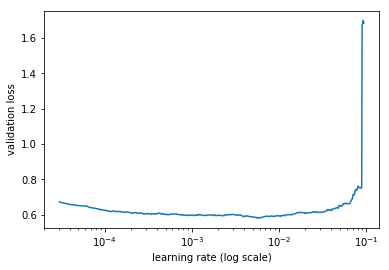

In [37]:
m.lr_find()
m.sched.plot(100)

In [38]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.593395   0.519555  
    1      0.567637   0.531164                                  
    2      0.564241   0.534897                                  



[array([0.5349])]

In [39]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.557257   0.554228  
    1      0.543662   0.550468                                  
    2      0.54298    0.558443                                  
    3      0.548422   0.562322                                  
    4      0.546592   0.564195                                  



[array([0.5642])]

In [40]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.540284   0.561343  
    1      0.543986   0.575734                                  
    2      0.533061   0.594761                                  
    3      0.545306   0.59385                                   
    4      0.529264   0.604829                                  
    5      0.509833   0.604778                                  
    6      0.515508   0.611846                                  
    7      0.510022   0.608767                                  
    8      0.49649    0.63605                                   
    9      0.4992     0.642808                                  
    10     0.502441   0.642769                                  
    11     0.489212   0.643048                                  
    12     0.497935   0.670844                                  
    13     0.470384   0.656924                                  
    14     0.473843   0.658302                           

[array([0.73427])]

In [41]:
m.save(modelName)

In [42]:
m.load(modelName)

## Validation

In [43]:
(x,y1)=m.predict_with_targs()

In [44]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2018-06-19 23:41:00,6730.200195,2018-06-19 23:41:00,0,0
2018-06-19 23:42:00,6727.189941,2018-06-19 23:42:00,1,0
2018-06-19 23:43:00,6730.910156,2018-06-19 23:43:00,0,0
2018-06-19 23:44:00,6731.310059,2018-06-19 23:44:00,0,0
2018-06-19 23:45:00,6737.779785,2018-06-19 23:45:00,0,1
2018-06-19 23:46:00,6734.160156,2018-06-19 23:46:00,0,0
2018-06-19 23:47:00,6734.169922,2018-06-19 23:47:00,0,0
2018-06-19 23:48:00,6730.520020,2018-06-19 23:48:00,0,0
2018-06-19 23:49:00,6737.779785,2018-06-19 23:49:00,0,0


Calculate the percent accuracy on the validation set

In [45]:
p.calculate_accuracy(valpred)

{'F1Score': 0.549,
 'totalAccuracy': 0.737,
 'buyAccuracy': 0.197,
 'sellAccuracy': 0.901,
 'totalBuyActions': 4646,
 'successfulBuyPredictions': 916}

In [46]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 7605.0,
 'endClose': 6559.99,
 'startAmount': 15000,
 'endAmount': 15962.563062165576,
 'buyAndHoldPercentIncrease': -13.741,
 'percentIncrease': 6.417,
 'percentDifference': 20.158,
 'totalTrades': 1403}

In [47]:
# p.plot_profit(p.net_profit_df)

In [48]:
p.net_profit_df

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-06 04:01:00,7605.000000,2018-06-06 04:01:00,0,0,15000.000000,0.000000
2018-06-06 04:02:00,7605.009766,2018-06-06 04:02:00,0,0,15000.000000,0.000000
2018-06-06 04:03:00,7605.009766,2018-06-06 04:03:00,0,0,15000.000000,0.000000
2018-06-06 04:04:00,7607.939941,2018-06-06 04:04:00,0,0,15000.000000,0.000000
2018-06-06 04:05:00,7615.009766,2018-06-06 04:05:00,0,0,15000.000000,0.000000
2018-06-06 04:06:00,7611.040039,2018-06-06 04:06:00,0,0,15000.000000,0.000000
2018-06-06 04:07:00,7614.700195,2018-06-06 04:07:00,0,0,15000.000000,0.000000
2018-06-06 04:08:00,7607.850098,2018-06-06 04:08:00,0,0,15000.000000,0.000000
2018-06-06 04:09:00,7610.629883,2018-06-06 04:09:00,0,0,15000.000000,0.000000


## Test

In [49]:
np.argmax(m.predict(True), axis =1)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0])

In [50]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-06-20 01:21:00,2018-06-20 01:21:00,6584.990234,1,0
2018-06-20 01:22:00,2018-06-20 01:22:00,6585.250000,1,1
2018-06-20 01:23:00,2018-06-20 01:23:00,6588.490234,0,1
2018-06-20 01:24:00,2018-06-20 01:24:00,6589.180176,0,1
2018-06-20 01:25:00,2018-06-20 01:25:00,6588.330078,0,0
2018-06-20 01:26:00,2018-06-20 01:26:00,6585.000000,1,0
2018-06-20 01:27:00,2018-06-20 01:27:00,6578.100098,1,1
2018-06-20 01:28:00,2018-06-20 01:28:00,6578.100098,1,1
2018-06-20 01:29:00,2018-06-20 01:29:00,6580.000000,1,1


In [51]:
p.calculate_accuracy(testPred)

{'F1Score': 0.538,
 'totalAccuracy': 0.728,
 'buyAccuracy': 0.101,
 'sellAccuracy': 0.975,
 'totalBuyActions': 2821,
 'successfulBuyPredictions': 285}

In [52]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6584.99,
 'endClose': 6071.53,
 'startAmount': 15000,
 'endAmount': 14769.741488141906,
 'buyAndHoldPercentIncrease': -7.797,
 'percentIncrease': -1.535,
 'percentDifference': 6.262,
 'totalTrades': 238}

In [53]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-20 01:21:00,2018-06-20 01:21:00,6584.990234,1,0,15000.000000,0.000000
2018-06-20 01:22:00,2018-06-20 01:22:00,6585.250000,1,1,0.000000,2.277818
2018-06-20 01:23:00,2018-06-20 01:23:00,6588.490234,0,1,0.000000,2.277818
2018-06-20 01:24:00,2018-06-20 01:24:00,6589.180176,0,1,0.000000,2.277818
2018-06-20 01:25:00,2018-06-20 01:25:00,6588.330078,0,0,15007.015857,0.000000
2018-06-20 01:26:00,2018-06-20 01:26:00,6585.000000,1,0,15007.015857,0.000000
2018-06-20 01:27:00,2018-06-20 01:27:00,6578.100098,1,1,0.000000,2.281360
2018-06-20 01:28:00,2018-06-20 01:28:00,6578.100098,1,1,0.000000,2.281360
2018-06-20 01:29:00,2018-06-20 01:29:00,6580.000000,1,1,0.000000,2.281360


In [55]:
# p.plot_profit(p.net_profit_df)